<a href="https://colab.research.google.com/github/hhduke2014/marked-beetle-analysis/blob/main/0819ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [125]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]

['PaperedControl20d.tif',
 'PaperedControl20d_light.tif',
 'PaperedControl21v.tif',
 'PaperedControl21v_light.tif']

In [126]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 760


In [127]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [128]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

760

In [129]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl20d.tif,marked
1,PaperedControl21v.tif,marked
2,PaperedControl21d.tif,marked
3,PaperedControl22v.tif,marked
4,PaperedControl22d.tif,marked
...,...,...
755,PaperedControl18v.tif,marked
756,PaperedControl18d.tif,marked
757,PaperedControl19v.tif,marked
758,PaperedControl19d.tif,marked


In [130]:
df['category'].value_counts()

marked      482
unmarked    278
Name: category, dtype: int64

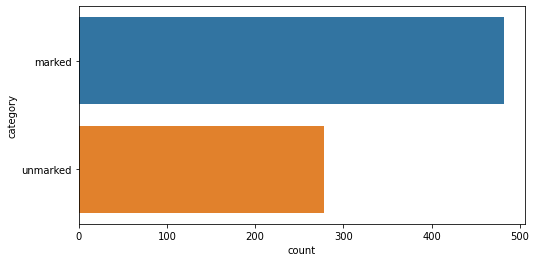

In [131]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [132]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [133]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [134]:
tmp_df = df.sample(9)
tmp_df

,filename,category
533,NoPaperedMixed22v.tif,unmarked
745,PaperedControl12d.tif,marked
509,NoPaperedMixed10v.tif,unmarked
248,PaperedTransparent64v.tif,marked
692,NoPaperedMixed1v.tif,unmarked
208,PaperedTransparent44v.tif,marked
689,PaperedMixed50v.tif,marked
336,PaperedControlTest81d.tif,marked
700,NoPaperedMixed5v.tif,unmarked


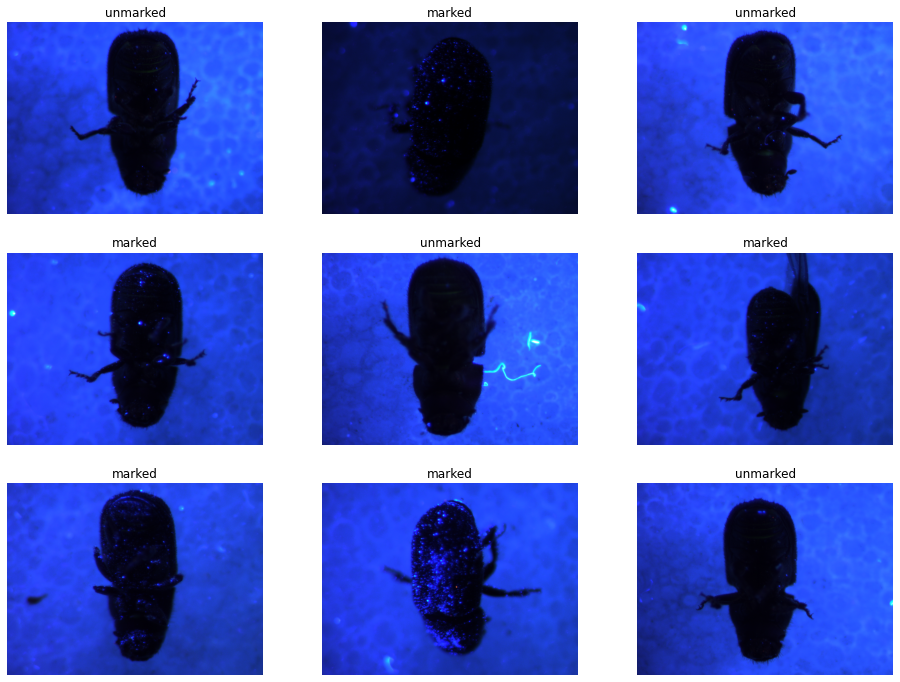

In [135]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [136]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

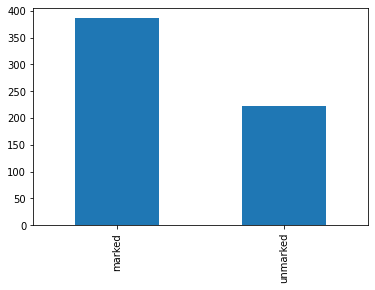

In [137]:
train_df['category'].value_counts().plot.bar()

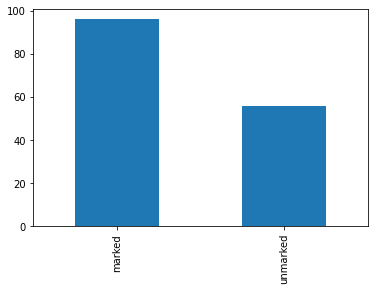

In [138]:
validate_df['category'].value_counts().plot.bar()

In [140]:
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 32

In [141]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [142]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
                    )

In [143]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 608 validated image filenames belonging to 2 classes.


In [144]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 152 validated image filenames belonging to 2 classes.


In [145]:
from tensorflow.keras import layers
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [146]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3,resnet50
def create_model():
  base = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=2)
        # Freeze the pretrained weights resnet50.ResNet50
  base.trainable = False
 #for layer in model.layers[:-40]:  # Training just part of the architecture do not optimize the performance
    #    layer.trainable = False
  model = Sequential()
  model.add(base)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  #model.add(Flatten())
  model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  return model
model = create_model()
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_40  (None, 2048)              0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_68 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 2)                 514       
Total params: 24,120,962
Trainable params: 529,154
Non-trainable params: 23,591,808
___________________________________

In [147]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [148]:
def Model_fit():
    
    model = create_model()
    '''Compiling the model'''
    #unfreeze_model(model)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("resnet_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [149]:
results = Model_fit()

Epoch 1/50
19/19 [==============================] - 459s 24s/step - loss: 0.6738 - accuracy: 0.7434 - val_loss: 0.6006 - val_accuracy: 0.7422


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
19/19 [==============================] - 439s 23s/step - loss: 0.5954 - accuracy: 0.8224 - val_loss: 0.3678 - val_accuracy: 0.8594
Epoch 3/50
19/19 [==============================] - 438s 23s/step - loss: 0.5863 - accuracy: 0.8174 - val_loss: 0.3884 - val_accuracy: 0.8438
Epoch 4/50
19/19 [==============================] - 427s 23s/step - loss: 0.6060 - accuracy: 0.8191 - val_loss: 0.4278 - val_accuracy: 0.8359

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/50
19/19 [==============================] - 430s 23s/step - loss: 0.4666 - accuracy: 0.8257 - val_loss: 0.3650 - val_accuracy: 0.8359
Epoch 6/50
19/19 [==============================] - 435s 23s/step - loss: 0.3246 - accuracy: 0.8717 - val_loss: 0.3623 - val_accuracy: 0.8594
Epoch 7/50
19/19 [==============================] - 426s 22s/step - loss: 0.3609 - accuracy: 0.8734 - val_loss: 0.3239 - val_accuracy: 0.8594
Epoch 8/50
19/19 [==============================] - 435s 23s/step 

In [150]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8733552694320679
Val_Cat-Acc:  0.890625


In [151]:
print('Train_Cat-Loss: ', min(results.history['loss']))
print('Val_Cat-Loss: ', min(results.history['val_loss']))

Train_Cat-Loss:  0.3245939612388611
Val_Cat-Loss:  0.27947723865509033


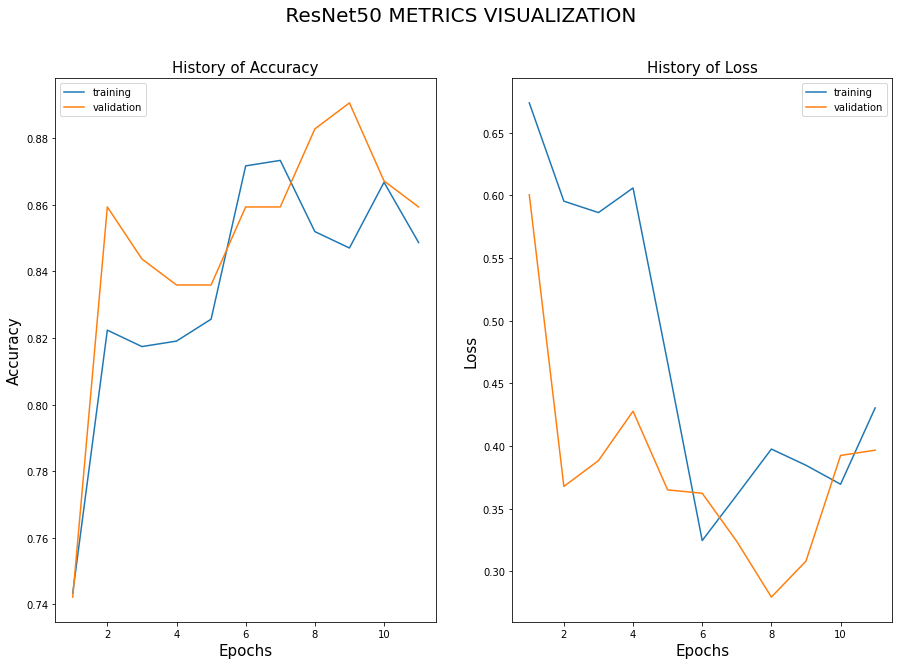

In [196]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" ResNet50 METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [153]:
import keras

final_model = keras.models.load_model('resnet_model.h5')

In [159]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
73,PaperedControl56v.tif,marked
464,NoPaperedGreen72d.tif,unmarked
655,PaperedMixed33v.tif,marked
585,NoPaperedMixed48v.tif,unmarked
690,PaperedMixed50d.tif,marked
116,PaperedControl77d.tif,marked
26,PaperedControl33d.tif,marked
182,PaperedTransparent31v.tif,marked
400,NoPaperedGreen16d.tif,unmarked
665,PaperedMixed38v.tif,marked


In [160]:
nb_samples = tmp_df1.shape[0]

In [161]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator = test_gen.flow_from_dataframe(
    tmp_df1, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10 validated image filenames.


In [162]:
predict = final_model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [163]:
tmp_df1['prediction'] = np.argmax(predict, axis=-1)
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
73,PaperedControl56v.tif,marked,marked
464,NoPaperedGreen72d.tif,unmarked,unmarked
655,PaperedMixed33v.tif,marked,marked
585,NoPaperedMixed48v.tif,unmarked,unmarked
690,PaperedMixed50d.tif,marked,unmarked
116,PaperedControl77d.tif,marked,marked
26,PaperedControl33d.tif,marked,marked
182,PaperedTransparent31v.tif,marked,unmarked
400,NoPaperedGreen16d.tif,unmarked,unmarked
665,PaperedMixed38v.tif,marked,unmarked


In [164]:
to_samples = df.shape[0]

In [191]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator1 = test_gen.flow_from_dataframe(
    df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 760 validated image filenames.


In [192]:
predict = final_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))

In [190]:
predict

array([[1.0000000e+00, 1.0594688e-08],
       [1.0000000e+00, 6.1533036e-09],
       [1.0000000e+00, 2.5947409e-09],
       ...,
       [9.5872974e-01, 4.1270331e-02],
       [9.9175137e-01, 8.2486775e-03],
       [1.0000000e+00, 2.6640528e-08]], dtype=float32)

In [193]:
df['prediction'] = np.argmax(predict, axis=-1)
df["prediction"] = df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
df

,filename,category,prediction
0,PaperedControl20d.tif,marked,marked
1,PaperedControl21v.tif,marked,marked
2,PaperedControl21d.tif,marked,marked
3,PaperedControl22v.tif,marked,marked
4,PaperedControl22d.tif,marked,marked
...,...,...,...
755,PaperedControl18v.tif,marked,marked
756,PaperedControl18d.tif,marked,marked
757,PaperedControl19v.tif,marked,marked
758,PaperedControl19d.tif,marked,marked


In [194]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(df['category'])
y_pred=list(df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])

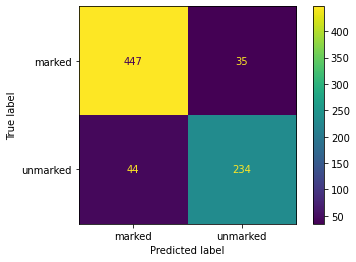

In [195]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d") 

In [ ]:
final_modell = keras.models.load_model('best_model.h5')

In [ ]:
preds=[]
for image_id in tmp_df1.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize((600,600))
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_modell.predict(image)))
tmp_df1["prediction1"]=preds

In [ ]:
tmp_df1["prediction1"] = tmp_df1["prediction1"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction,prediction1
464,NoPaperedGreen55d.tif,unmarked,marked,marked
324,PaperedTransparent84d.tif,marked,marked,marked
134,PaperedControl76v_light.tif,marked,marked,marked
411,NoPaperedGreen19d.tif,unmarked,marked,unmarked
190,PaperedTransparent22v.tif,marked,marked,marked
136,PaperedControl76d_light.tif,marked,marked,marked
659,PaperedMixed17d.tif,marked,marked,marked
0,PaperedControl20d.tif,marked,marked,marked
773,NoPaperedGreen9v.tif,unmarked,marked,marked
743,PaperedControl4v.tif,marked,marked,marked
